In [48]:
!unzip tumor-dataset

Archive:  tumor-dataset
 extracting: brainTumorDataPublic_1-766.zip  
 extracting: brainTumorDataPublic_1533-2298.zip  
 extracting: brainTumorDataPublic_767-1532.zip  
 extracting: brainTumorDataPublic_2299-3064.zip  
 extracting: cvind.mat               
 extracting: README.txt              


In [49]:
!unzip "brainTumorDataPublic_*.zip" -d "./rawdata"

Archive:  brainTumorDataPublic_2299-3064.zip
  inflating: ./rawdata/2299.mat      
  inflating: ./rawdata/2300.mat      
  inflating: ./rawdata/2301.mat      
  inflating: ./rawdata/2302.mat      
  inflating: ./rawdata/2303.mat      
  inflating: ./rawdata/2304.mat      
  inflating: ./rawdata/2305.mat      
  inflating: ./rawdata/2306.mat      
  inflating: ./rawdata/2307.mat      
  inflating: ./rawdata/2308.mat      
  inflating: ./rawdata/2309.mat      
  inflating: ./rawdata/2310.mat      
  inflating: ./rawdata/2311.mat      
  inflating: ./rawdata/2312.mat      
  inflating: ./rawdata/2313.mat      
  inflating: ./rawdata/2314.mat      
  inflating: ./rawdata/2315.mat      
  inflating: ./rawdata/2316.mat      
  inflating: ./rawdata/2317.mat      
  inflating: ./rawdata/2318.mat      
  inflating: ./rawdata/2319.mat      
  inflating: ./rawdata/2320.mat      
  inflating: ./rawdata/2321.mat      
  inflating: ./rawdata/2322.mat      
  inflating: ./rawdata/2323.mat      
  inf

In [50]:
%pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [51]:
import h5py
import os
import matplotlib.pyplot as plt
import random
import shutil

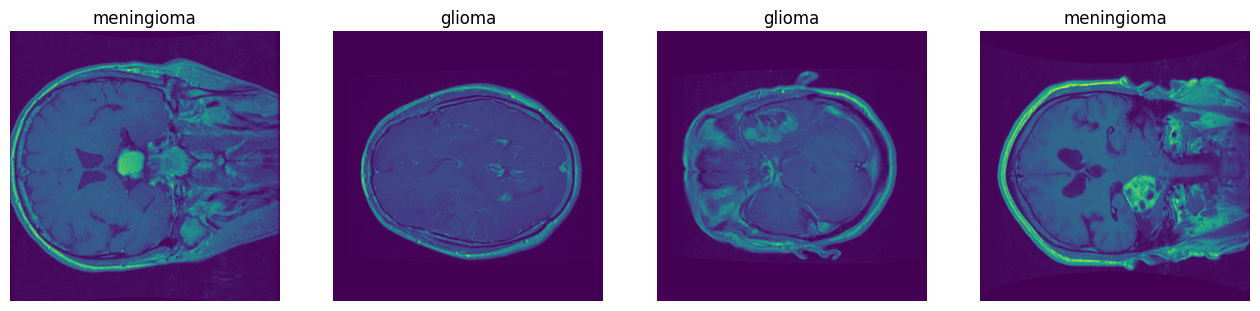

In [52]:
label = {1: 'meningioma', 2: 'glioma', 3: 'pituitary'}

base_path = './rawdata/'
all_mat_files = os.listdir(base_path)

fig, axes = plt.subplots(1, 4, figsize=(16, 16))

for idx, mat_file in enumerate(all_mat_files[:4]):
  file_path = base_path + mat_file

  with h5py.File(file_path, 'r') as file:
    axes[idx].imshow(file['cjdata']['image'])
    axes[idx].set_title(label[file['cjdata']['label'][0][0]])
    axes[idx].axis('off')

plt.show()

#### Export the images to raw png files under thier respective names

In [53]:
!mkdir images "images/meningioma" "images/glioma" "images/pituitary"

In [54]:
new_base_path = './images'

for idx, mat_file in enumerate(all_mat_files):
  file_path = base_path + mat_file

  with h5py.File(file_path, 'r') as file:
    file_label = file['cjdata']['label'][0][0]
    new_path = f"{new_base_path}/{label[file_label]}/{idx}.png"

    plt.imsave(new_path, file['cjdata']['image'])

#### Take some randomly from each category for later testing with the website

In [55]:
!mkdir "website-testing" "website-testing/meningioma" "website-testing/glioma" "website-testing/pituitary"

In [56]:
# Source and destination directories
source_dirs = ["images/meningioma", "images/glioma", "images/pituitary"]
destination_dirs = ["website-testing/meningioma", "website-testing/glioma", "website-testing/pituitary"]

# Number of files to move from each source directory
num_files_to_move = 15

# Move files randomly from each source directory to the corresponding destination directory
for source_dir, destination_dir in zip(source_dirs, destination_dirs):
    # Ensure destination directory exists
    os.makedirs(destination_dir, exist_ok=True)
    
    # List all files in the source directory
    files_to_move = os.listdir(source_dir)
    
    # Randomly select num_files_to_move files
    files_to_move = random.sample(files_to_move, num_files_to_move)
    
    # Move selected files to the destination directory
    for file in files_to_move:
        file_path = os.path.join(source_dir, file)
        destination_path = os.path.join(destination_dir, file)
        shutil.move(file_path, destination_path)

#### Prepare the tensorflow data

In [57]:
import tensorflow as tf

In [58]:
# this makes sure GPU is allocated on demand not upfront
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [59]:
validation_split = .2
test_split = .2

data = tf.keras.utils.image_dataset_from_directory(
  'images',
  batch_size=150,
  shuffle=True,
  validation_split=validation_split,
  subset='training',
  seed=101
)

Found 3019 files belonging to 3 classes.
Using 2416 files for training.


##### resize data between 0 and 1

In [60]:
data = data.map(lambda x, y: (x/256, y))

In [61]:
no_train_samples = int(len(data) * .6)
no_val_samples = int(len(data) * validation_split)
no_test_samples = int(len(data) * test_split)

# Split the dataset into training, validation, and test sets separately
train_dataset = data.take(no_train_samples)
val_dataset = data.skip(no_train_samples).take(no_val_samples)
test_dataset = data.skip(no_train_samples + no_val_samples).take(no_test_samples)

#### Data augumentaton

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, RandomFlip, RandomRotation, RandomZoom

In [63]:
# # this randomly generates more images from the data by flipping, zooming and rescaling it
# data_augmentation = Sequential(
#   [
#     RandomFlip("horizontal_and_vertical", input_shape=(256, 256, 3)),
#     RandomRotation(0.2),
#   ]
# )

In [64]:
# first parameter in conv2d represents number of features to extract
# Also this builds the deep neural network
model = Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
  MaxPooling2D(),
  Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
  MaxPooling2D(),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D(),
  Conv2D(128, (3, 3), activation='relu'),
  Flatten(),
  Dense(256, activation='relu'),
  Dropout(0.5),
  Dense(128, activation='relu'),
  Dropout(0.5),
  Dense(64, activation='relu'),
  Dropout(0.5),
  Dense(32, activation='relu'),
  Dropout(0.5),
  Dense(3, activation='softmax')
])

In [65]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)

In [66]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 30, 30, 64)       

In [67]:
early_stopping = tf.keras.callbacks.EarlyStopping(
  min_delta=0.01,
  patience=5,
  restore_best_weights=True
)

In [68]:
# auto adjust leanring rate
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [69]:
hist = model.fit(
  train_dataset,
  epochs=100,
  validation_data=val_dataset,
  callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x150x1x256xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x150x1x128xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/4e1473ee-9f66-11ee-8daf-cedaeb4cabe2/Library/Caches/com.apple.xbs/Sources/MetalPerform

10/10 [==============================] - 11s 769ms/step - loss: 1.1901 - accuracy: 0.3753 - val_loss: 1.0904 - val_accuracy: 0.4289 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 10s 858ms/step - loss: 1.0771 - accuracy: 0.4500 - val_loss: 1.0737 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 9s 732ms/step - loss: 1.0717 - accuracy: 0.4607 - val_loss: 1.0702 - val_accuracy: 0.4422 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 9s 784ms/step - loss: 1.0561 - accuracy: 0.4533 - val_loss: 1.0521 - val_accuracy: 0.4378 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 10s 821ms/step - loss: 1.0312 - accuracy: 0.4760 - val_loss: 0.9779 - val_accuracy: 0.4578 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - 9s 815ms/step - loss: 0.9958 - accuracy: 0.5000 - val_loss: 0.9941 - val_accuracy: 0.6022 - lr: 0.0010
Epoch 7/100
10/10 [==============================] - 9s 763ms/step - loss

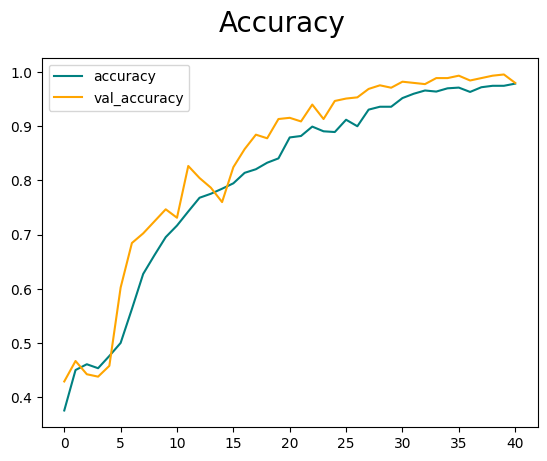

In [70]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [71]:
from tensorflow.keras.metrics import Precision, Recall

In [72]:
pre = Precision()
re = Recall()

In [73]:
for batch in test_dataset.as_numpy_iterator():
    X, y = batch
    
    # Convert true labels to one-hot encoded format
    y_one_hot = tf.keras.utils.to_categorical(y, num_classes=3)
    
    # Predict probabilities using the model
    yhat = model.predict(X)
    
    # Update precision and recall metrics
    pre.update_state(y_one_hot, yhat)
    re.update_state(y_one_hot, yhat)

5/5 [==============================] - 0s 30ms/step


In [74]:
print(f"Precision {pre.result().numpy()}, Recall {re.result().numpy()}")

Precision 0.9933333396911621, Recall 0.9933333396911621


In [75]:
model.save('./server/tumor-multiclass-model.h5')